в 2017 году Яндекс выпустила новую **библиотеку градиентного бустинга CatBoost**, которая обаладает следующими особенностями:
- динамический бустинг
- новый подход к обработке категориальных признаков

Подход к обработке признаков предназначен для борьбы со смещением прогноза, который вызван утечкой информации о зависимой переменной

Процесс построения деревьев включает четыре этапа:
- квантование количественных признаков
- преобразование категориальных признаков в количественные
- выбор структуры дерева (здесь важен выбор типа бутстрепа)
- вычисление значений листьев (для этого применяется динамический бустинг)

Кроме того, CatBoost предлагает собственные стратегии обработки пропусков количественных переменных.

**`Квантование` в CatBoost (параметр border_count)** — это процесс преобразования непрерывных числовых признаков в дискретные бины (корзины).
- Разделение на интервалы: Непрерывные признаки делятся на интервалы (бины) на основе их значений. Количество бинов может быть задано пользователем или определено автоматически.

- Замена значений: Каждый числовой признак заменяется номером бина, к которому он принадлежит. Таким образом, вместо хранения и обработки исходных числовых значений, алгоритм работает с индексами бинов.

- Ускорение вычислений: Квантование позволяет существенно уменьшить объем вычислений и памяти, необходимых для обработки данных. Поскольку вместо большого количества уникальных числовых значений используется ограниченное количество бинов, вычисления становятся быстрее и эффективнее.

>Чем меньше border_count, тем быстрее обучение, но менее точнее

**Преобразование категориальных признаков в количественные**

Catboost выполняет случайную перестановку данных и рассчитывает статистику зависимой переменной на основе только тех данных, которые находятся выше текущего наблюдения, считая их "историей". Это помогает избежать утечки данных (data leakage) при обучении модели.

Основные этапы процесса:

- Случайная перестановка данных: на обучающем наборе данных выполняется случайная перестановка наблюдений.
- Расчет статистик для текущего наблюдения: статистика зависимой переменной для каждого наблюдения рассчитывается на основе данных, которые были встречены ранее в этой перестановке.
- Повторение процесса для снижения дисперсии: для уменьшения дисперсии и повышения точности статистики, CatBoost выполняет несколько случайных перестановок.
Таким образом, CatBoost кодирует категориальные признаки, используя "историю" предыдущих наблюдений, что позволяет модели лучше работать с такими признаками.

Важные параметры:
- one_hot_max_size
Описание: Устанавливает порог для использования one-hot кодирования для категориальных признаков. Если количество уникальных значений категориального признака не превышает значение one_hot_max_size, то для этого признака будет использовано one-hot кодирование. В противном случае применяется target encoding.
По умолчанию: 2 (то есть one-hot кодирование будет применяться только к бинарным признакам)
- cat_features
Описание: Список индексов или имен столбцов категориальных признаков в данных. CatBoost автоматически определяет категориальные признаки, но можно явно указать их с помощью этого параметра.
- target_stat
Описание: Указывает, какую статистику использовать для кодирования категориальных признаков (например, среднее или медиану по целевой переменной)
- max_ctr_complexity
max_ctr_complexity определяет максимальную сложность комбинаций категориальных признаков, которые будут использоваться для построения CTR-признаков. Под "сложностью" здесь понимается количество категориальных признаков, участвующих в комбинации.

  - max_ctr_complexity=1: Используются только одиночные признаки, без комбинаций.
  - max_ctr_complexity=2: В комбинациях участвуют до двух признаков (например, A и B).

  Комбинирование категориальных признаков
  есть два признака: A и B, и каждый из них может принимать значения {A1, A2, A3} и {B1, B2} соответственно, то можно создать комбинации этих признаков: (A1, B1), (A1, B2), (A2, B1) и т.д.






**Забывчивые деревья**  
 CatBoost может использовать симметричные «забывчивые» деревья (oblivious trees)t. Эти деревья строятся так, что на определённом уровне для всех узлов применяется одно и то же правило разбиения. Такой подход подразумевает, что дерево "забывает", что уже использовало это правило разбиения на этом уровне в другой ветви.

Основные особенности забывчивых деревьев:

- Симметричность: все ветви дерева на одном уровне используют одно и то же условие разбиения.
- Стабильность: забывчивые деревья более устойчивы к изменениям гиперпараметров, менее склонны к переобучению и обеспечивают более быструю оценку прогноза.

Разработчики утверждают, что такие деревья более устойчивые и не склонные к переобучению

<img src="https://drive.google.com/uc?export=view&id=1HjyLkZcE0Ip_zxa16suiJ2KkjL9gGVoC" width="400"/>


Параметр `grow_policy` определяет стратегию роста деревьев, то есть то, как именно будут добавляться новые узлы в дерево во время его построения. В CatBoost поддерживаются несколько стратегий роста деревьев, каждая из которых имеет свои особенности:

- SymmetricTree (по умолчанию):

Это стратегия симметричного роста дерева, при которой все узлы на одном уровне используют одно и то же условие разбиения (так называемые забывчивые деревья). Симметричные деревья проще и быстрее в вычислении, они устойчивы к изменению гиперпараметров и менее склонны к переобучению.

- Depthwise:

Дерево строится с добавлением новых узлов на текущем уровне, прежде чем двигаться на следующий уровень глубины. Это стандартная стратегия для большинства градиентных бустингов, например, в XGBoost и LightGBM. Этот подход часто приводит к более глубоким деревьям с большими узлами, что может быть полезно для более сложных моделей.

- Lossguide:

Это стратегия, при которой новые узлы добавляются к тем листам, где это приводит к максимальному уменьшению функции потерь. Таким образом, дерево "глубже" исследует те ветви, где возможны наибольшие улучшения качества модели. Это может привести к более глубоким, но менее широким деревьям.


Выбор `grow_policy` зависит от характера данных и задачи. Симметричные деревья (SymmetricTree) могут быть хорошим выбором для задач с большим количеством категориальных признаков, в то время как Depthwise и Lossguide могут быть полезны для более сложных, иерархических данных.









[**Бутстреп (bootstrap_type)**](https://catboost.ai/en/docs/references/training-parameters/common#bootstrap_type) — метод, используемый для создания случайных подвыборок данных при построении каждого нового дерева в модели.
Основные типы бутстрепа в CatBoost:
- Poisson (supported for GPU only)

Описание: Для каждой выборки случайным образом определяется количество раз, когда каждое наблюдение попадет в подвыборку, используя распределение Пуассона.
Особенности: Этот метод обычно приводит к тому, что некоторые наблюдения появляются несколько раз, а другие не появляются вовсе. Poisson-бутстреп может быть полезен, когда вам нужно более случайное распределение выборок.

- Bayesian

Описание: Использует байесовский бутстреп, где веса выборок выбираются из априорного распределения, что позволяет моделировать данные более естественным образом.
Особенности: Байесовский бутстреп может улучшить качество модели за счет учета априорной информации, но требует дополнительных вычислительных затрат.
Дополнительный параметр: bagging_temperature — определяет степень случайности. При увеличении значения этого параметра происходит более сильное увеличение вариативности весов.

- Bernoulli

Описание: Классический бутстреп, при котором каждое наблюдение выбирается в подвыборку с определенной вероятностью (обычно 50%).

- No

Описание: Отключает бутстреп. Это означает, что модель будет использовать весь обучающий набор данных для каждого дерева.

Бутстреп помогает создавать более устойчивые модели, уменьшая вероятность переобучения за счет введения случайности в процесс выбора данных для обучения каждого дерева.

Производительность: В зависимости от типа бутстрепа и параметров, таких как bagging_temperature или subsample, можно контролировать степень случайности, что может влиять на качество предсказаний и скорость обучения модели.

Использование ресурсов: Включение бутстрепа может увеличивать вычислительные затраты, но в то же время может существенно улучшить обобщающую способность модели.

Когда использовать:
- Если вы замечаете, что модель переобучается, стоит рассмотреть использование бутстрепа.
- Для больших наборов данных и сложных задач Bayesian или Poisson бутстреп может дать лучшее качество модели.
- Для простых задач или небольших наборов данных можно попробовать отключить бутстреп или использовать Bernoulli бутстреп для ускорения процесса обучения.


Градиентный бустинг:

В стандартном градиентном бустинге значения в листьях дерева рассчитываются как среднее значение градиента по всем наблюдениям, попавшим в данный лист.
Проблема возникает, когда оценка делается на тех же самых наблюдениях, которые использовались для построения модели. Это может привести к смещению прогнозов, так как модель может "переучиться" на этих данных.


Подход в CatBoost:

В CatBoost используется метод, позволяющий избежать этого смещения.
Вместо того, чтобы вычислять значения на всех наблюдениях сразу, CatBoost применяет те же самые случайные перестановки обучающего набора, которые использовались для вычисления статистики зависимой переменной.
Таким образом, значения в листьях рассчитываются как среднее значение градиента по всем наблюдениям, попавшим в лист раньше рассматриваемого наблюдения в данной случайной перестановке.
Этот подход называется "динамическим бустингом", так как он динамически пересчитывает значение в листьях, уменьшая вероятность смещения и переобучения.
Почему это важно?
Использование случайных перестановок и динамического подхода позволяет CatBoost более эффективно обучаться на данных, избегая переобучения и улучшая обобщающую способность модели.

In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.9 MB/s eta 0:00:00


In [ ]:
# импортируем необходимые библиотеки, классы,
# функции и набор данных
import numpy as np
import pandas as pd
# import shap
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     cross_validate)
from sklearn.metrics import accuracy_score, auc
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from catboost.datasets import titanic
from catboost import (CatBoostClassifier,
                      CatBoostRegressor,
                      Pool, cv)
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

In [ ]:
!gdown 1cvCNt9EL-NurjFEJU-iRPG56ae535O3h
data = pd.read_csv('/content/Bank_Customer_Churn_Prediction.csv', index_col='customer_id')

Downloading...
From: https://drive.google.com/uc?id=1cvCNt9EL-NurjFEJU-iRPG56ae535O3h
To: /content/Bank_Customer_Churn_Prediction.csv
100% 562k/562k [00:00<00:00, 29.7MB/s]


In [ ]:
y = data.pop('churn')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 15634602 to 15628319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 859.4+ KB


In [ ]:
assert data.isna().sum().unique()[0] == 0

In [ ]:
cat_features = ['country', 'gender']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((8000, 10), (2000, 10))

In [ ]:
# создаем экземпляр класса CatBoostClassifier
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Accuracy',
    custom_metric='F1',
    random_seed=42,
    logging_level='Silent'
)

In [ ]:
# обучаем модель
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
    # plot=True,
    plot_file='train_val_curves.html'
)

In [ ]:
# вычисляем правильность на обучающей выборке
print("Accurace on train: {:.3f}".format(
    model.score(X_train, y_train)))
# вычисляем правильность на проверочной выборке
print("Accurace on test: {:.3f}".format(
    model.score(X_val, y_val)))

Accurace on train: 0.923
Accurace on test: 0.870


`l2_leaf_reg в CatBoost` —  параметр регуляризации, который контролирует силу L2-регуляризации (или Ridge-регуляризации) на весах в листьях деревьев.

In [ ]:
# увеличиваем значение l2_leaf_reg, выводим значения accuracy
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Accuracy',
    custom_metric='F1',
    l2_leaf_reg=30,
    random_seed=42,
    logging_level='Verbose',
    early_stopping_rounds=50  # Остановка, если метрика не улучшается в течение 50 итераций
)

# обучаем модель
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
    plot=False,
    plot_file='train_val_curves_2.html'
)

0:	learn: 0.8506250	test: 0.8555000	best: 0.8555000 (0)	total: 14.2ms	remaining: 14.2s
1:	learn: 0.8527500	test: 0.8560000	best: 0.8560000 (1)	total: 25.7ms	remaining: 12.8s
2:	learn: 0.8543750	test: 0.8565000	best: 0.8565000 (2)	total: 36.9ms	remaining: 12.2s
3:	learn: 0.8556250	test: 0.8560000	best: 0.8565000 (2)	total: 49.3ms	remaining: 12.3s
4:	learn: 0.8548750	test: 0.8565000	best: 0.8565000 (2)	total: 60.1ms	remaining: 12s
5:	learn: 0.8536250	test: 0.8565000	best: 0.8565000 (2)	total: 71.8ms	remaining: 11.9s
6:	learn: 0.8526250	test: 0.8560000	best: 0.8565000 (2)	total: 82.6ms	remaining: 11.7s
7:	learn: 0.8525000	test: 0.8565000	best: 0.8565000 (2)	total: 93.9ms	remaining: 11.6s
8:	learn: 0.8525000	test: 0.8560000	best: 0.8565000 (2)	total: 105ms	remaining: 11.5s
9:	learn: 0.8522500	test: 0.8570000	best: 0.8570000 (9)	total: 115ms	remaining: 11.4s
10:	learn: 0.8522500	test: 0.8575000	best: 0.8575000 (10)	total: 124ms	remaining: 11.1s
11:	learn: 0.8523750	test: 0.8575000	best: 0.8

In [ ]:
# вычисляем правильность на обучающей выборке
print("Accurace on train: {:.3f}".format(
    model.score(X_train, y_train)))
# вычисляем правильность на проверочной выборке
print("Accurace on test: {:.3f}".format(
    model.score(X_val, y_val)))

Accurace on train: 0.860
Accurace on test: 0.863


In [ ]:
# получим прогнозы и вероятности для первых 5 наблюдений
predictions = model.predict(X_val)
proba = model.predict_proba(X_val)
print(predictions[:5])
print("")
print(proba[:5])

[0 0 0 0 0]

[[0.84972287 0.15027713]
 [0.8886732  0.1113268 ]
 [0.78829902 0.21170098]
 [0.7276838  0.2723162 ]
 [0.843915   0.156085  ]]


а можно обучить так:

In [ ]:
# создаем словарь параметров и гиперпараметров
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'custom_metric': 'F1',
    'random_seed': 42,
    'logging_level': 'Silent'
}

In [ ]:
# создаем обучающий и проверочный пулы
train_pool = Pool(X_train,
                  y_train,
                  cat_features=cat_features)
validate_pool = Pool(X_val,
                     y_val,
                     cat_features=cat_features)

In [ ]:
# обучаем модель
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

In [ ]:
# строим ROC-кривую
curve = get_roc_curve(model, validate_pool)
(fpr, tpr, thresholds) = curve

# вычисляем AUC-ROC
roc_auc = auc(fpr, tpr)
roc_auc

0.8680692453974421

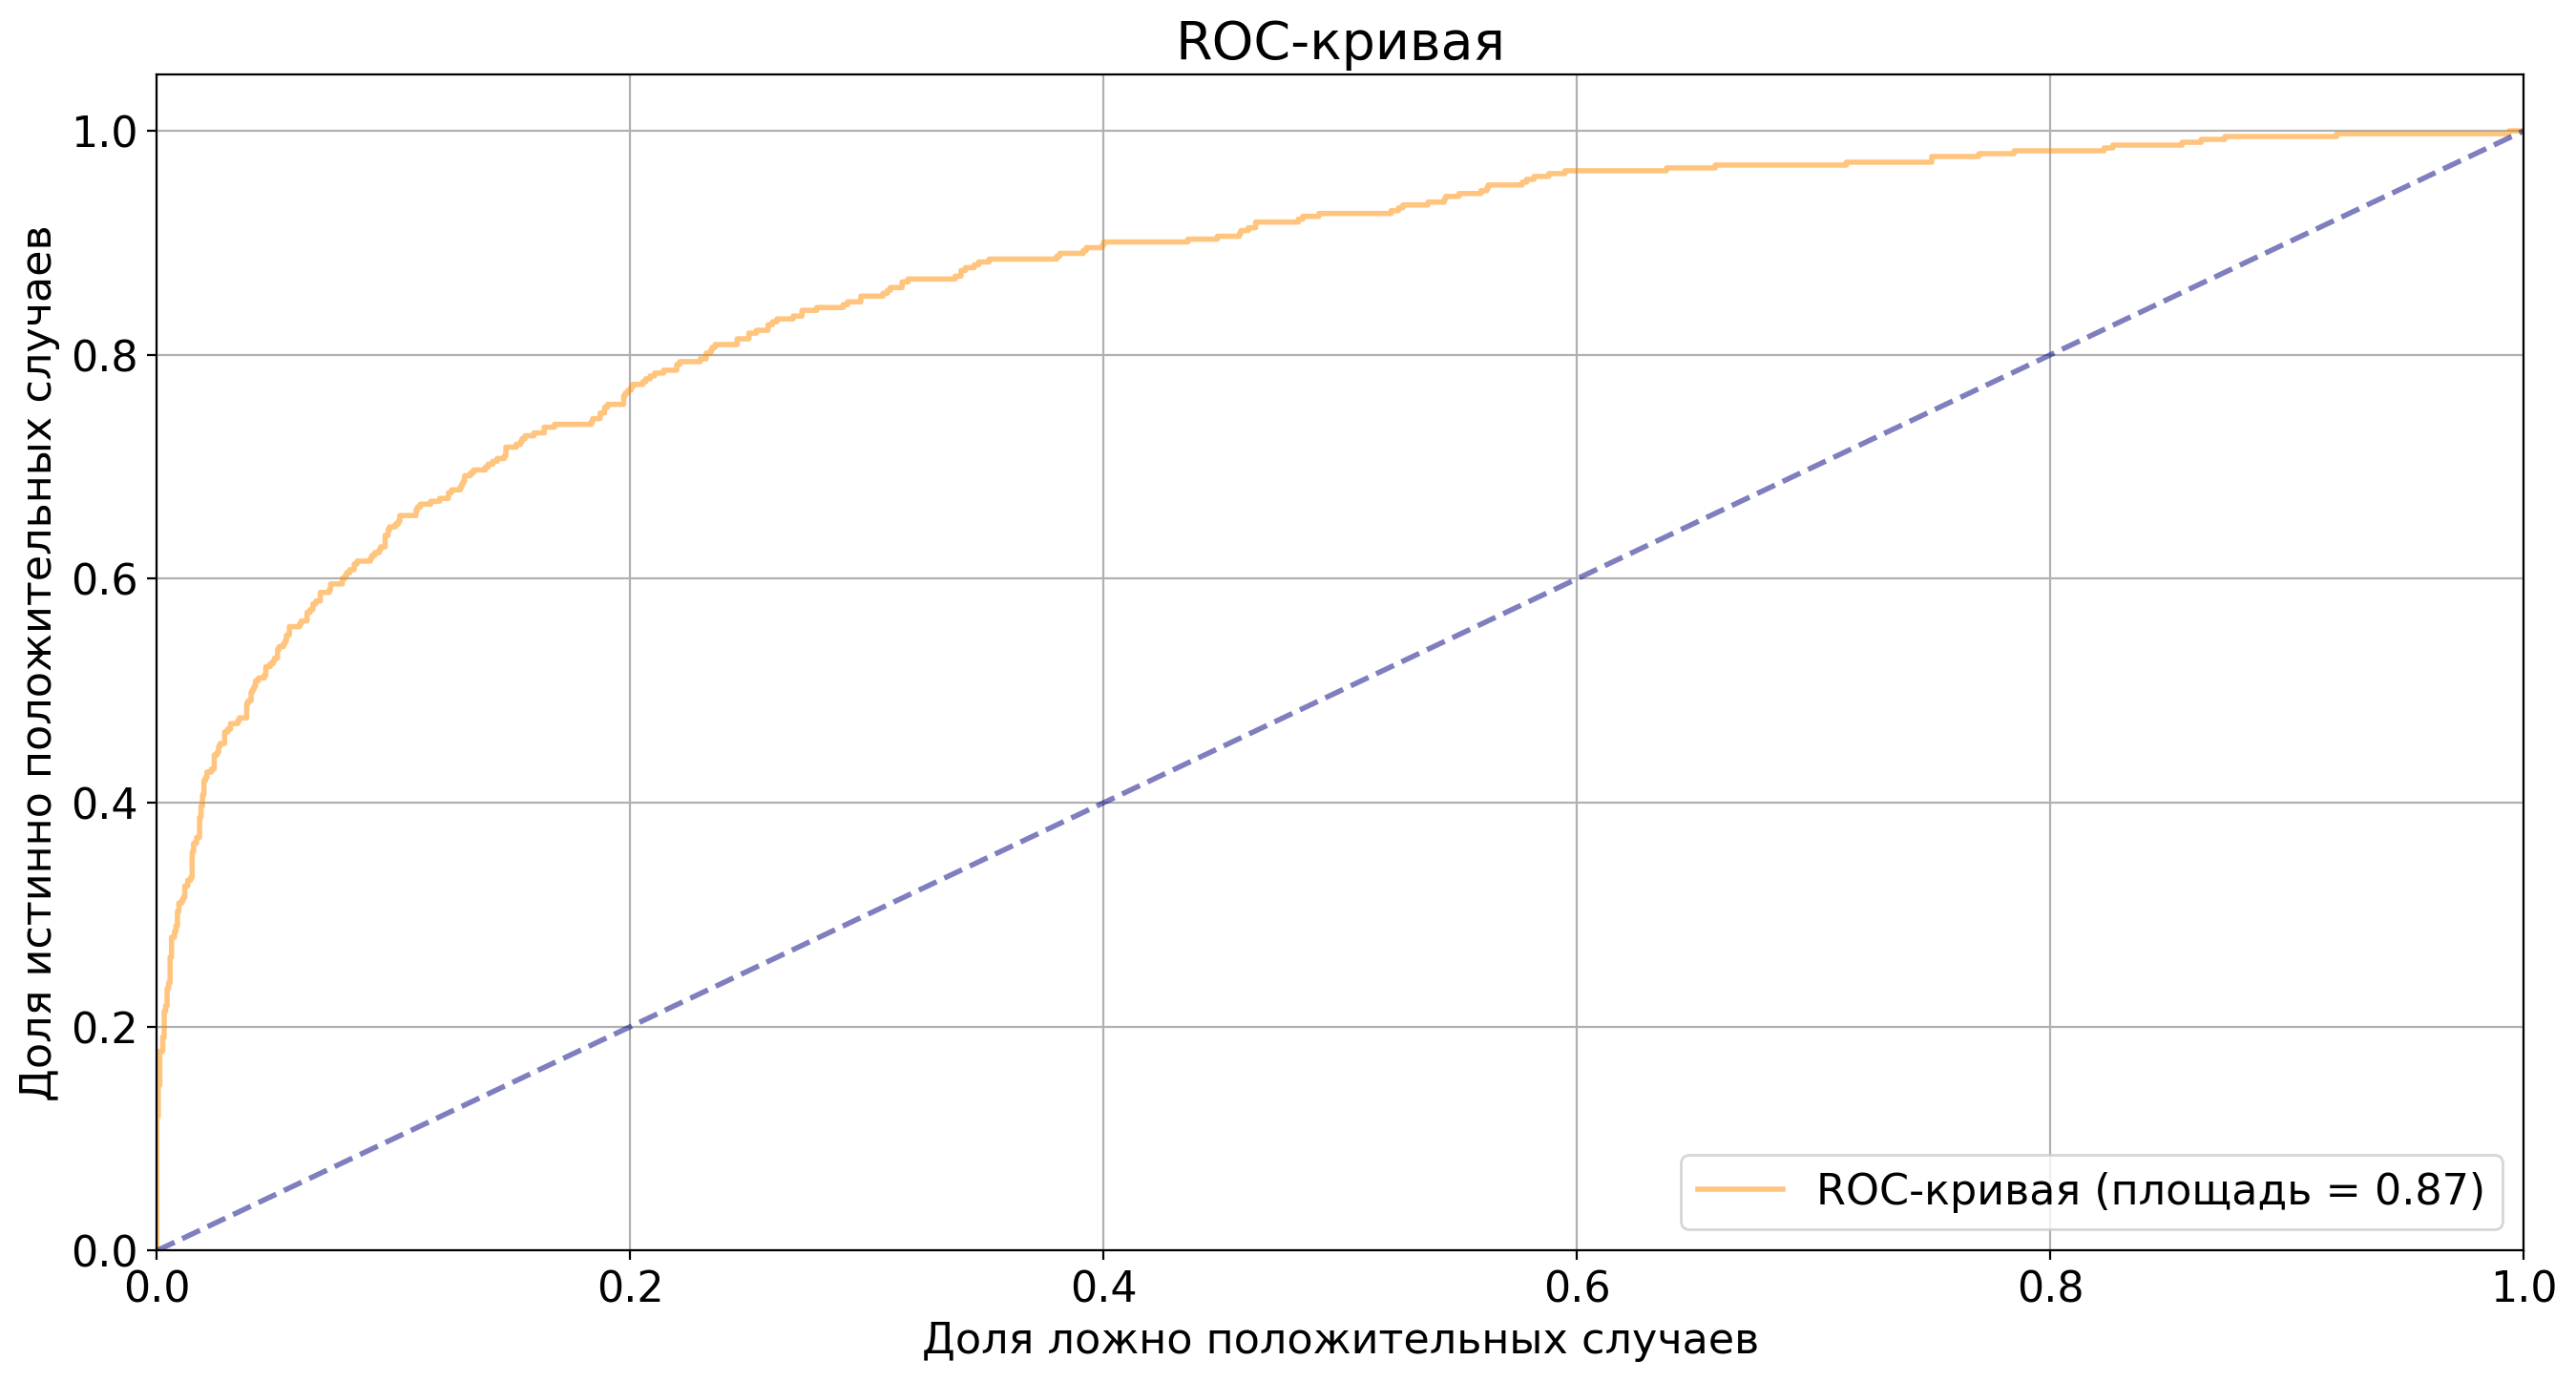

In [ ]:
# визуализируем ROC-кривую

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label="ROC-кривая (площадь = %0.2f)" % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel("Доля ложно положительных случаев", fontsize=16)
plt.ylabel("Доля истинно положительных случаев", fontsize=16)
plt.title("ROC-кривая", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
# получаем пороги, значения FPR и FNR по ROC-кривой
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

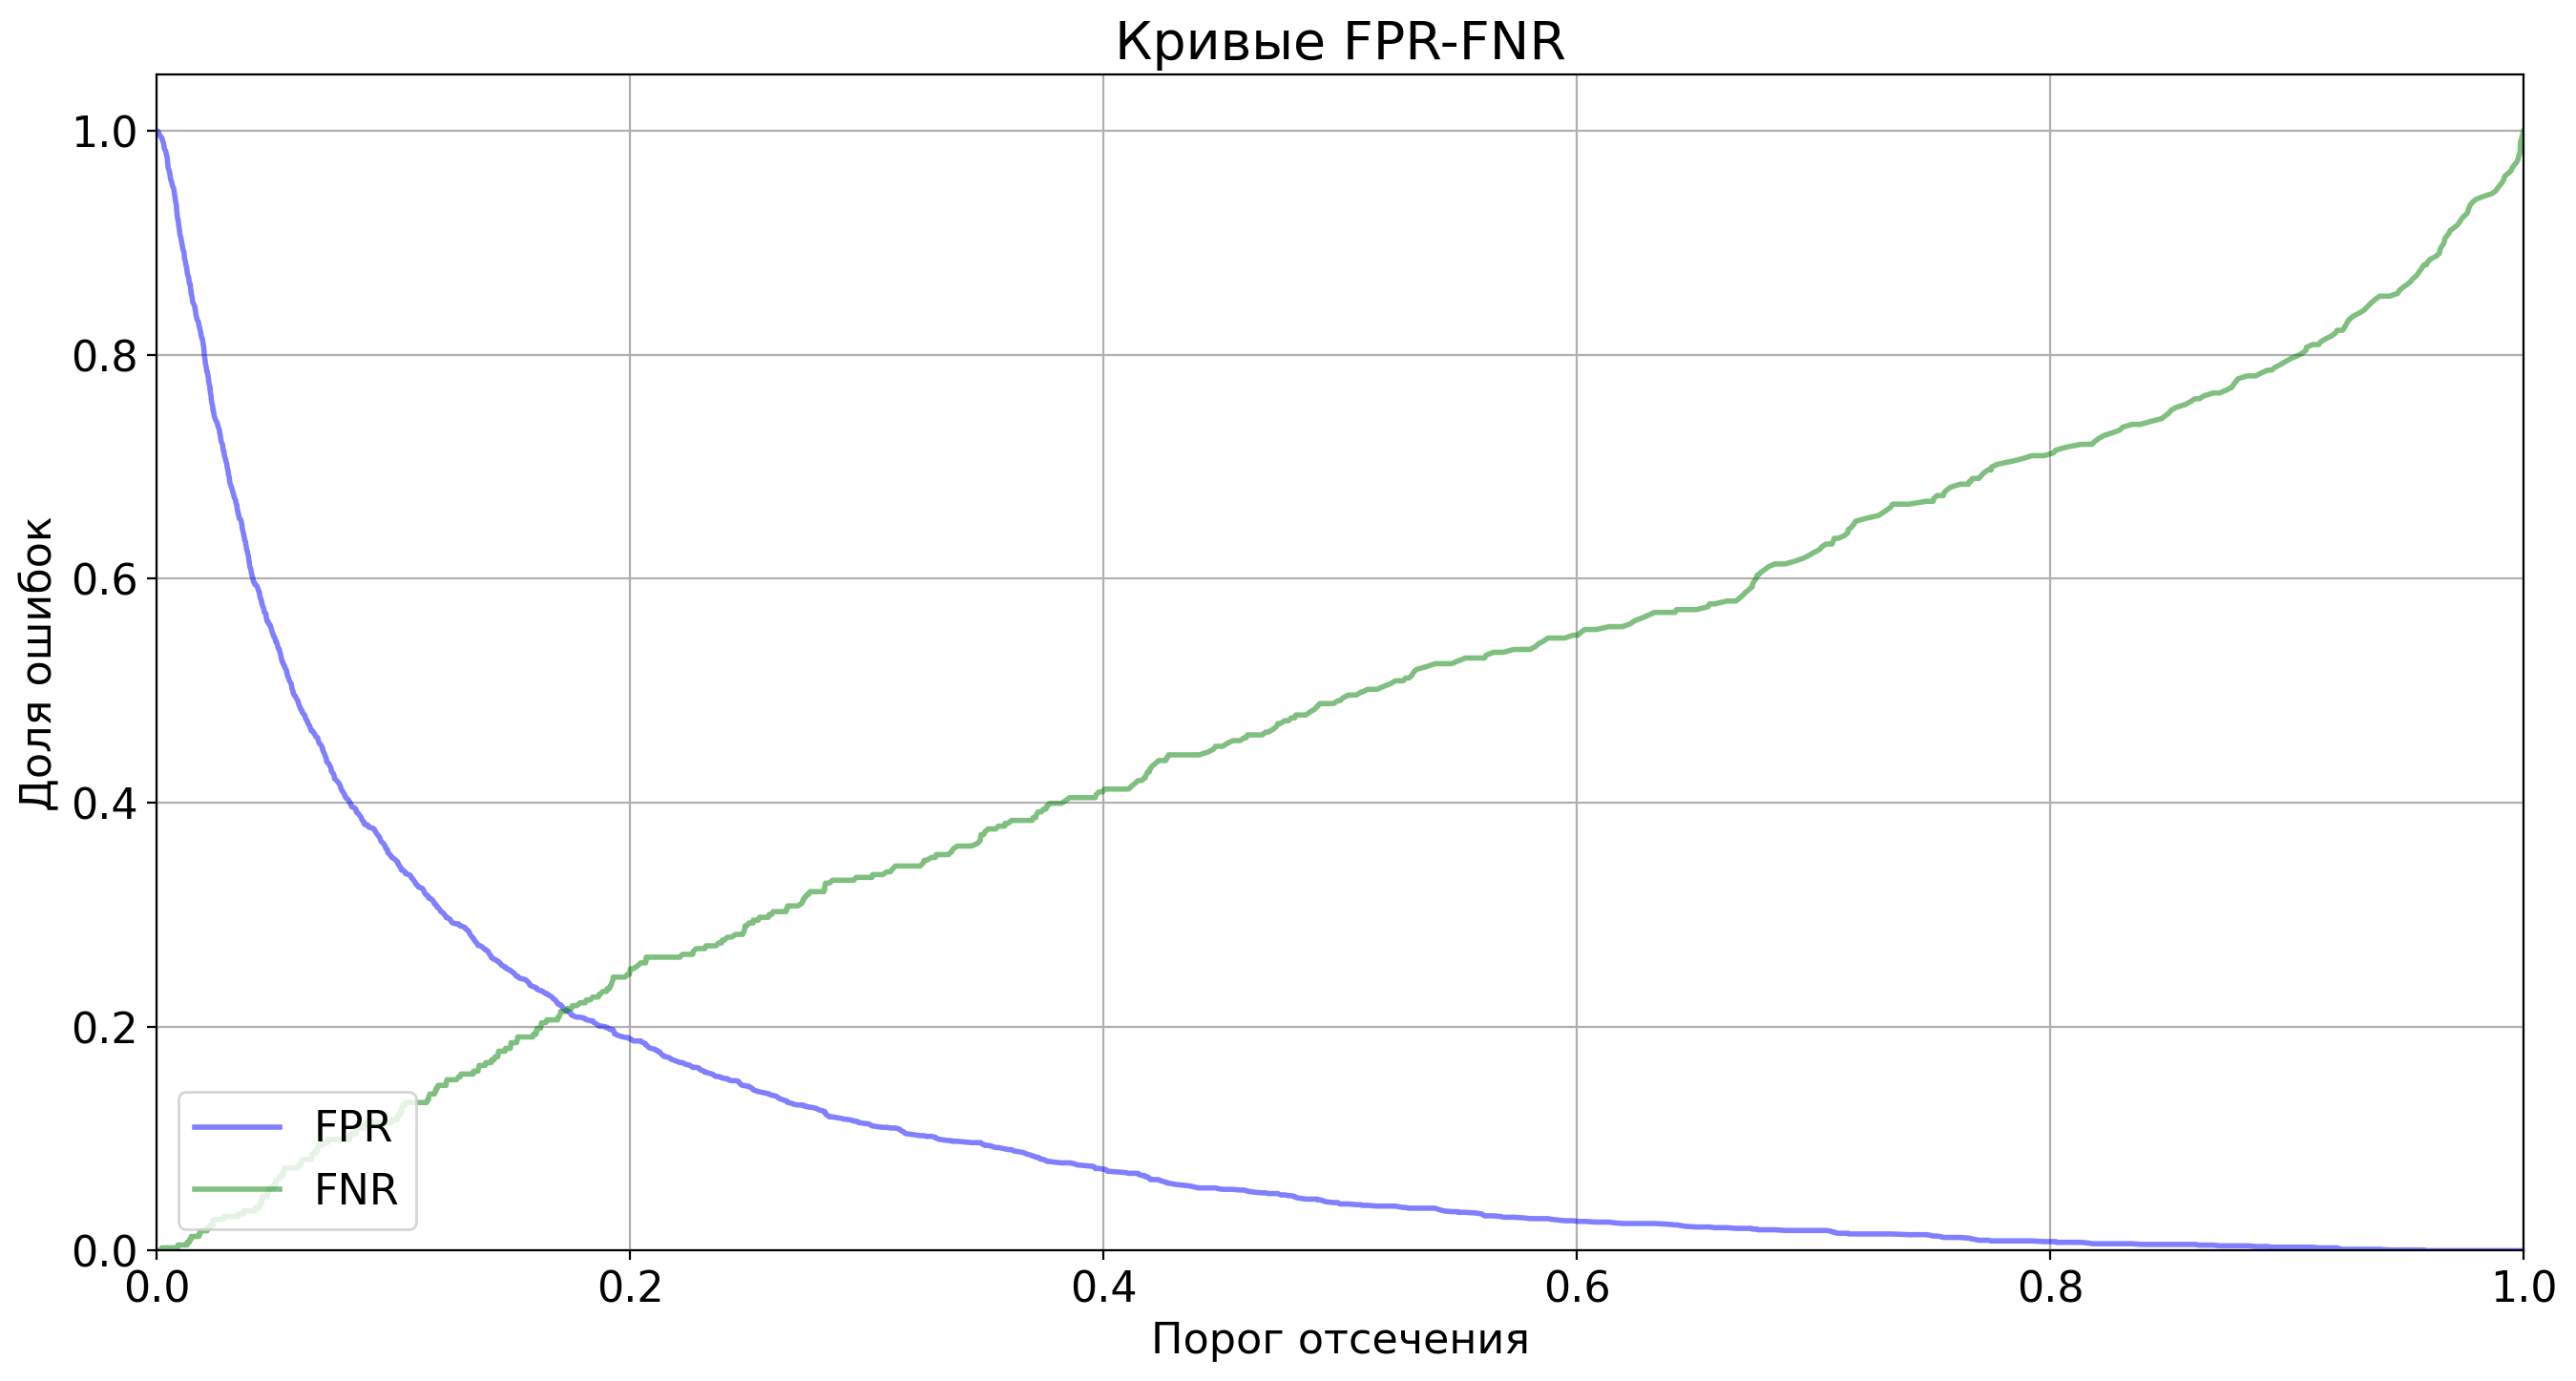

In [ ]:
# визуализируем кривые FPR-FNR
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue',
         lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green',
         lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel("Порог отсечения", fontsize=16)
plt.ylabel("Доля ошибок", fontsize=16)
plt.title("Кривые FPR-FNR", fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

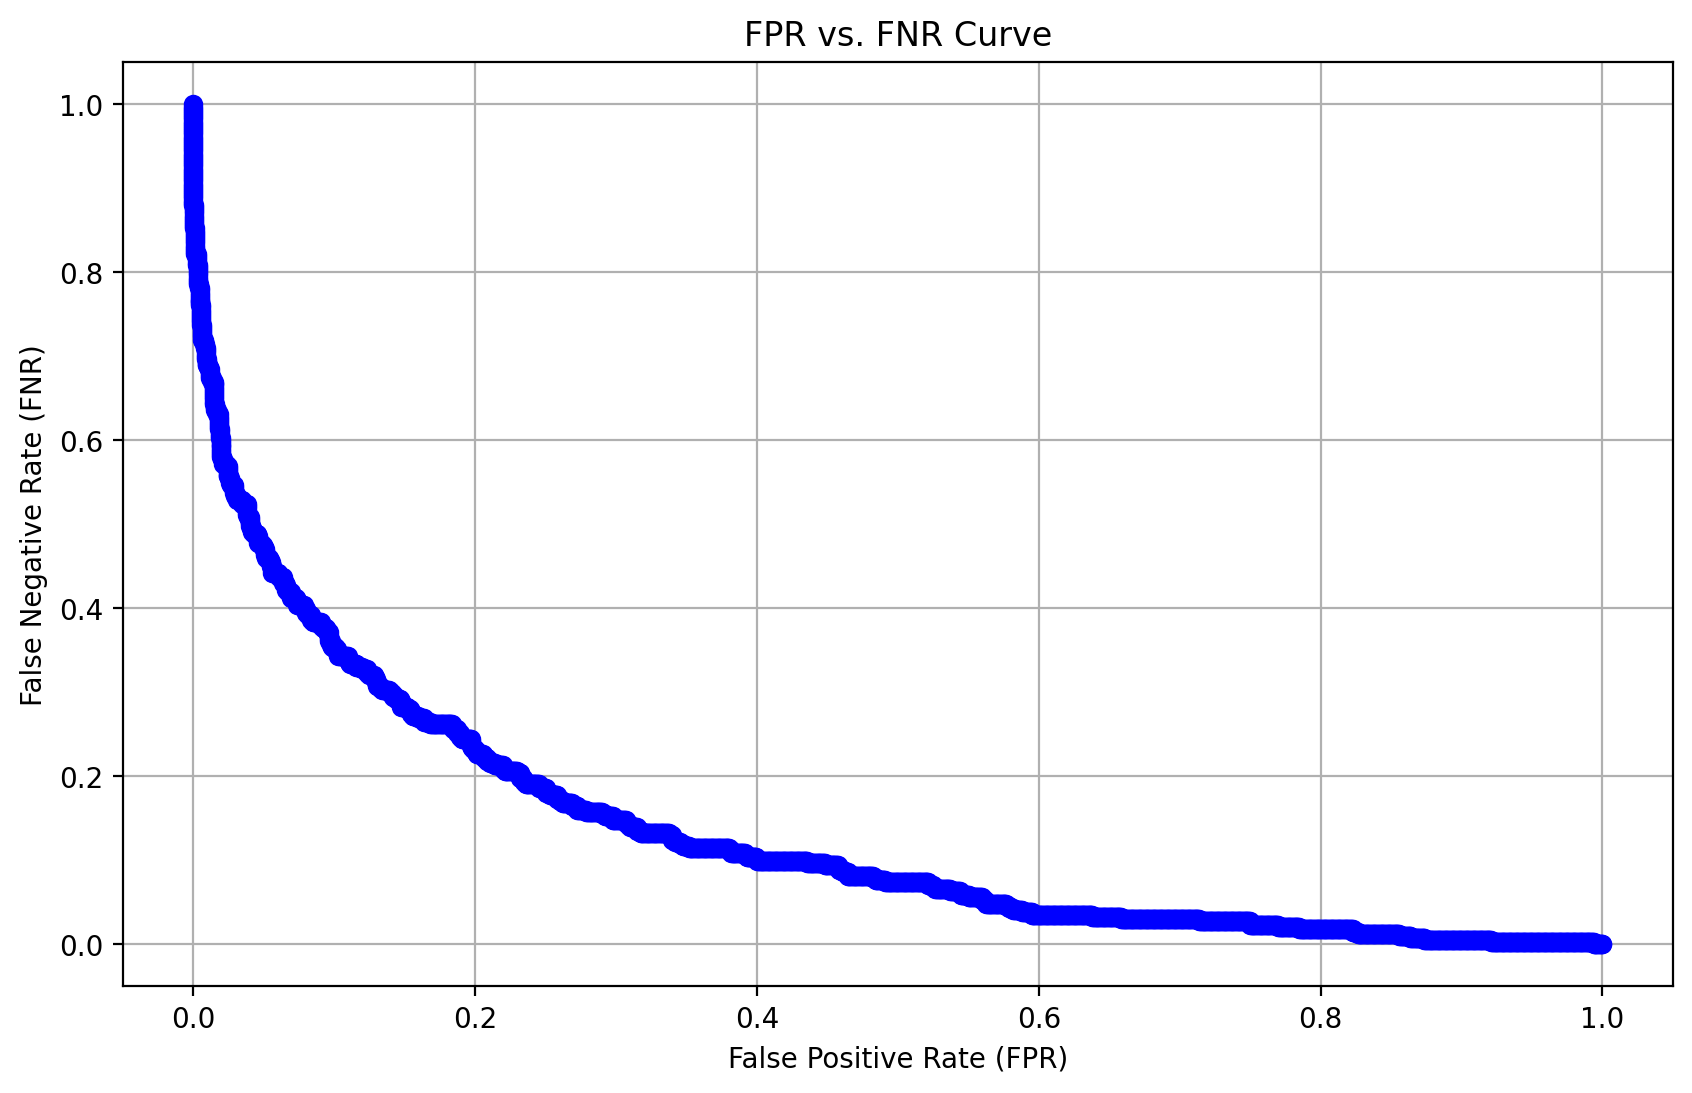

In [ ]:
# Построение кривой FPR-FNR
plt.figure(figsize=(10, 6))
plt.plot(fpr, fnr, marker='o', linestyle='-', color='b')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('False Negative Rate (FNR)')
plt.title('FPR vs. FNR Curve')
plt.grid(True)
plt.show()

In [ ]:
# сохраним модель
model.save_model('catboost_model.dump')
# загрузим модель
model = CatBoostClassifier()
model.load_model('catboost_model.dump');

In [ ]:
# сохраняем модель в виде скрипта Python
model.save_model('model.py',
                 format='python',
                 pool=train_pool)

In [ ]:
# выведем значения всех гиперпараметров
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Accuracy',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.1000000015,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=U

In [ ]:
# задаем значения гиперпараметров
cv_params = model.get_params()

# запускаем перекрестную проверку
cv_data = cv(
    Pool(data, y, cat_features=cat_features),
    cv_params,
    nfold=3,
    plot=False
)

In [ ]:
# посмотрим первые 5 итераций обучения
# в режиме перекрестной проверки
cv_data.head()

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std
0,0,0.8524,0.005917,0.85485,0.002470,0.668060,0.000056,0.667887,0.000314,0.527061,0.030212,0.534538,0.008981
1,1,0.8530,0.004130,0.85475,0.004603,0.645181,0.000105,0.644847,0.000688,0.515076,0.017541,0.521558,0.025949
2,2,0.8532,0.003620,0.85465,0.003934,0.624456,0.000538,0.623930,0.001100,0.520441,0.016885,0.525978,0.023072
3,3,0.8540,0.002887,0.85445,0.003897,0.607010,0.001986,0.606291,0.002423,0.519342,0.013664,0.520522,0.022120
4,4,0.8544,0.003589,0.85515,0.003501,0.588782,0.001697,0.587949,0.002444,0.521853,0.017645,0.524177,0.018785


In [ ]:
print("Наилучшее значение правильности перекрестной проверки с учетом\n"
      "стандартного отклонения: {:.3f}±{:.3f} на шаге {}".format(
          np.max(cv_data['test-Accuracy-mean']),
          cv_data['test-Accuracy-std'][cv_data['test-Accuracy-mean'].idxmax()],
          cv_data['test-Accuracy-mean'].idxmax())
)

Наилучшее значение правильности перекрестной проверки с учетом
стандартного отклонения: 0.865±0.003 на шаге 678


In [ ]:
print("Точечное наилучшее значение правильности\n"
      "перекрестной проверки: {:.3f}".format(
          np.max(cv_data['test-Accuracy-mean'])))

Точечное наилучшее значение правильности
перекрестной проверки: 0.865


In [ ]:
# записываем значения SHAP (вычисляем важности признаков
# по типу ShapValues), получаем массив NumPy размером
# количество наблюдений на количество переменных +
# столбец с ожидаемым (базовым) значением
shap_values = model.get_feature_importance(train_pool,
                                           type='ShapValues')
# подавляем экспоненциальную запись
np.set_printoptions(precision=None, suppress=True)
# смотрим форму массива значений SHAP
print(shap_values.shape)
# смотрим массив значений SHAP
shap_values

(8000, 11)


array([[-0.06070912, -0.04807294, -0.33564765, ..., -0.34572145,
         0.03105942, -2.11829657],
       [ 0.00385352,  0.30109097, -0.31815623, ..., -0.36251601,
        -0.82311916, -2.11829657],
       [ 0.15202081,  0.14241677, -0.19373901, ...,  0.59413848,
         0.01527679, -2.11829657],
       ...,
       [ 0.18847791, -0.0380745 ,  0.48481667, ...,  0.39919276,
        -0.1422148 , -2.11829657],
       [ 0.1998148 ,  0.18050541, -0.25373087, ...,  0.73319772,
        -0.12136049, -2.11829657],
       [-0.21615882,  0.69254038, -0.20198873, ..., -0.67706434,
         0.19993231, -2.11829657]])

In [ ]:
# убеждаемся, что базовое (ожидаемое) значение - это среднее
# значение прогнозов до применения сигмоид-преобразования
prediction = model.predict(train_pool, prediction_type='RawFormulaVal').mean()
print("базовое значение: %.3f" % prediction)

базовое значение: -2.105


In [ ]:
# записываем базовое (ожидаемое) значение - последнее значение
# в первой строке массива NumPy
expected_value = shap_values[0, -1]
# удаляем последнее значение из каждой строки,
# по сути удаляем столбец с базовыми значениями
shap_values = shap_values[:, :-1]
# проверяем форму массива
print(shap_values.shape)

(8000, 10)


In [ ]:
# pip install shap
import shap

In [ ]:
# запускаем JS-визуализацию для отображения
# графиков в тетрадках
shap.initjs()
# выводим вклады признаков для первого наблюдения
shap.force_plot(
    expected_value,
    shap_values[0,:],
    feature_names=train_pool.get_feature_names()
)

In [ ]:
# выводим вклады признаков для шестнадцатого наблюдения
shap.initjs()
shap.force_plot(
    expected_value,
    shap_values[15,:],
    feature_names=train_pool.get_feature_names()
)

In [ ]:
# то же самое можно получить с помощью класса
# TreeExplainer библиотеки shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value,
                shap_values[15,:],
                X_train.iloc[15,:])

In [ ]:
# выбираем интересующие нас наблюдения
test_objects = [X_train.iloc[0:1], X_train.iloc[15:16]]

# вычислим вероятности положительного класса
# для интересующих наблюдений
for obj in test_objects:
    print("Сырой прогноз = {:.2f}".format(
        model.predict(obj, prediction_type='RawFormulaVal')[0]))
    print("Вероятность положительного класса = {:.2f}\n".format(
        model.predict_proba(obj)[0][1]))

Сырой прогноз = -4.98
Вероятность положительного класса = 0.01

Сырой прогноз = -4.64
Вероятность положительного класса = 0.01



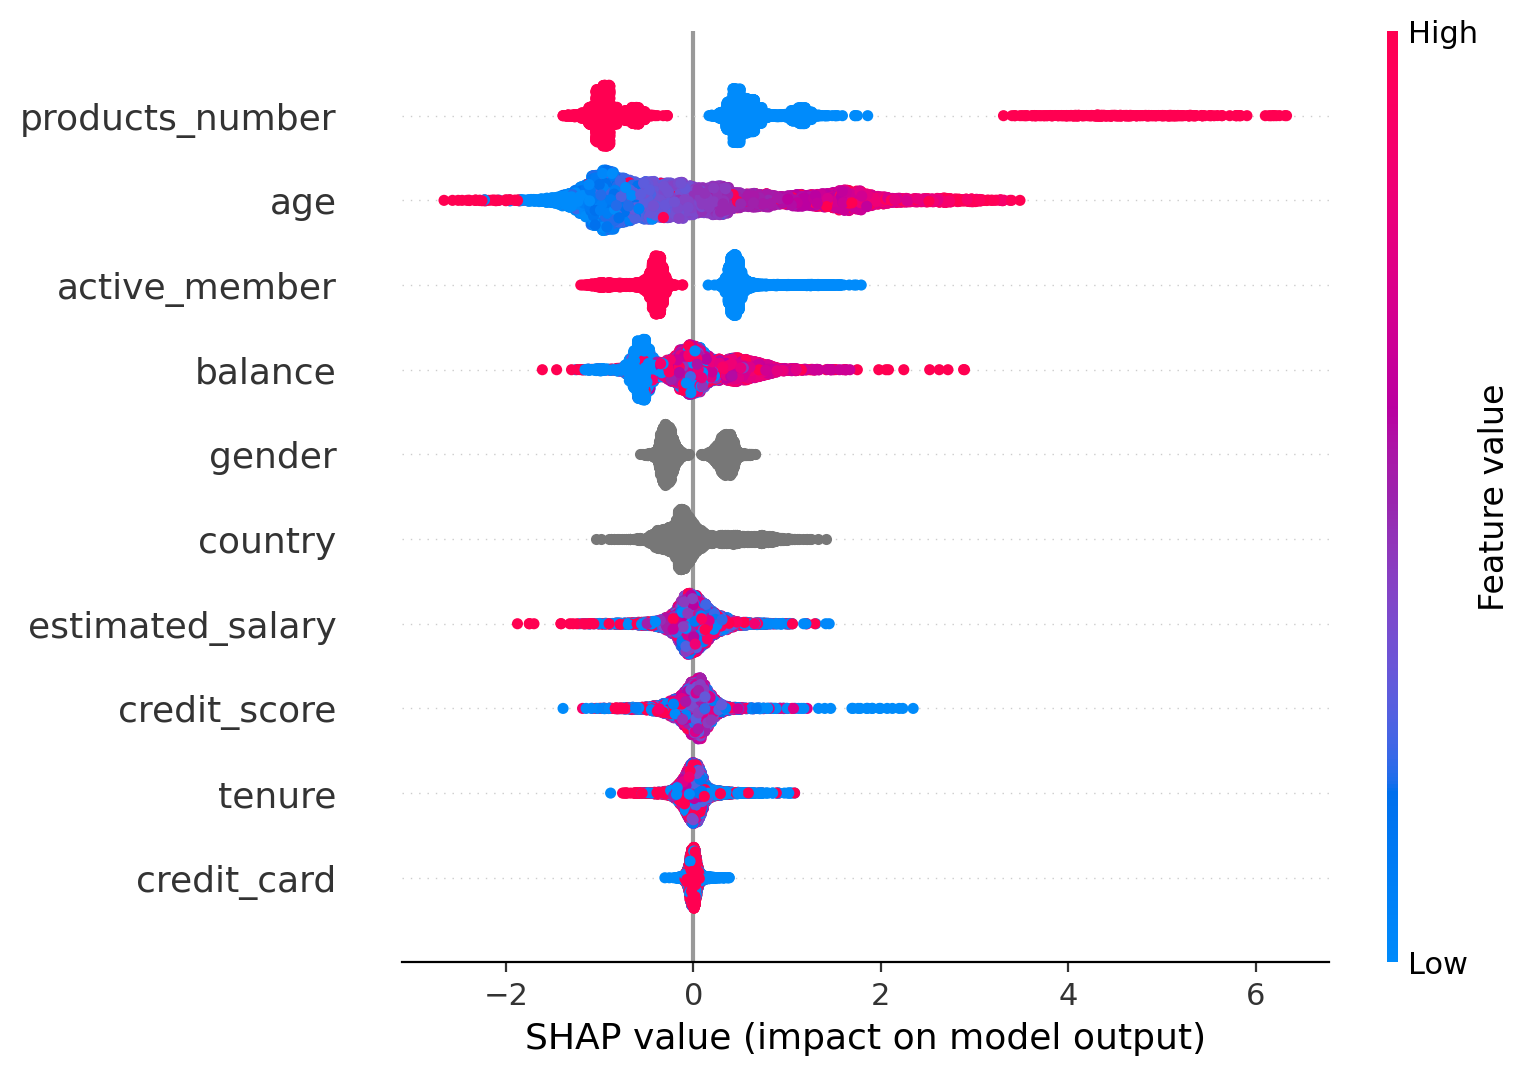

In [ ]:
# построим итоговый график вкладов признаков
shap.summary_plot(shap_values, X_train)